In [16]:
from torch.utils.data import Dataset, DataLoader
import json
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [17]:
file = '/Users/jared/Documents/Personal/ICL/courses/ADLS/mase/NASLib/naslib/data/zc_nasbench201.json'
with open(file, 'r') as f:
    data = json.load(f)
    data = data['cifar10']


targets = [data[arch]['val_accuracy'] for arch in data.keys()]
inputs = []

for arch in data.keys():

    inputs.append([data[arch].get(metric_name, 0)['score'] for metric_name in ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot','plain','snip','synflow','zen','flops','params'] ])
    

In [18]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


# Convert lists to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)


from sklearn.model_selection import train_test_split

# Assuming inputs and targets have been prepared
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)



# Create dataset instances
train_dataset = CustomDataset(inputs_train, targets_train)
test_dataset = CustomDataset(inputs_test, targets_test)

batch_size = 32  # You can adjust the batch size according to your needs

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(13, 1)
        # 3 inputs (zc metrics), 1 output (accuracy)

    def forward(self, x):
        return self.linear(x)
    
import torch.nn as nn
import torch.nn.functional as F

class NonLinearModel(nn.Module):
    def __init__(self):
        super(NonLinearModel, self).__init__()
        self.linear1 = nn.Linear(13, 13)  # First linear layer
        self.act1 = nn.ReLU()            # Non-linear activation function
        self.linear2 = nn.Linear(13, 1)  # Second linear layer to produce 1 output

    def forward(self, x):
        x = self.linear1(x)  # Pass input through the first linear layer
        x = self.act1(x)     # Apply non-linear activation
        x = self.linear2(x)  # Pass through the second linear layer
        return x

model = NonLinearModel()

# model = LinearModel()

# Loss and optimizer
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Tracking loss for plotting
train_losses = []
test_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss_train = 0.0
    for inputs_batch, targets_batch in train_loader:
        optimizer.zero_grad()
        outputs_train = model(inputs_batch)
        loss_train = criterion(outputs_train, targets_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item() * inputs_batch.size(0)
    
    epoch_loss_train = running_loss_train / len(train_loader.dataset)

    # Evaluation mode (no gradients)
    model.eval()
    running_loss_test = 0.0
    with torch.no_grad():
        for inputs_batch, targets_batch in test_loader:
            outputs_test = model(inputs_batch)
            loss_test = criterion(outputs_test, targets_batch)
            running_loss_test += loss_test.item() * inputs_batch.size(0)

    epoch_loss_test = running_loss_test / len(test_loader.dataset)

    # Save losses for plotting
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}')


Epoch [1/20], Train Loss: 17130.2252, Test Loss: 163.3008
Epoch [2/20], Train Loss: 42.0808, Test Loss: 3.9707
Epoch [3/20], Train Loss: 3.6581, Test Loss: 2.4933
Epoch [4/20], Train Loss: 3.4560, Test Loss: 3.2377
Epoch [5/20], Train Loss: 2.9791, Test Loss: 3.2057
Epoch [6/20], Train Loss: 3.0097, Test Loss: 2.3993
Epoch [7/20], Train Loss: 2.9745, Test Loss: 3.5609
Epoch [8/20], Train Loss: 3.7008, Test Loss: 4.3558
Epoch [9/20], Train Loss: 69.6250, Test Loss: 11.1623
Epoch [10/20], Train Loss: 8.7036, Test Loss: 6.1268
Epoch [11/20], Train Loss: 5.7950, Test Loss: 5.3899
Epoch [12/20], Train Loss: 5.0027, Test Loss: 4.2584
Epoch [13/20], Train Loss: 5.0976, Test Loss: 4.6328
Epoch [14/20], Train Loss: 4.9034, Test Loss: 3.6485
Epoch [15/20], Train Loss: 4.8222, Test Loss: 5.1638
Epoch [16/20], Train Loss: 4.4462, Test Loss: 4.1689
Epoch [17/20], Train Loss: 4.8680, Test Loss: 4.7263
Epoch [18/20], Train Loss: 4.5612, Test Loss: 3.5458
Epoch [19/20], Train Loss: 4.4114, Test Loss: 

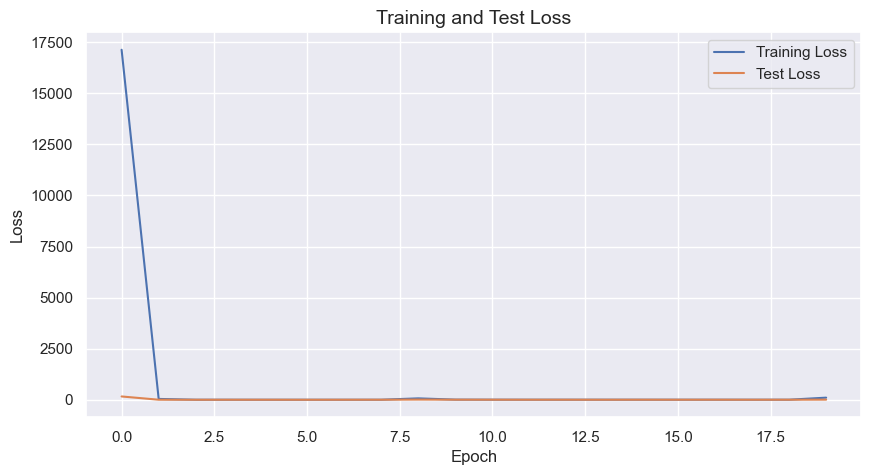

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')

# Add title and labels
plt.title('Training and Test Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add legend
plt.legend()

# Optionally, set the ylim if you want to focus on a specific range of losses
# plt.ylim([0, 10])

# Show the plot
plt.show()

[ 92.01113129  88.92323303  92.7587204  ...  84.76209259  75.72364044
 111.66668701]


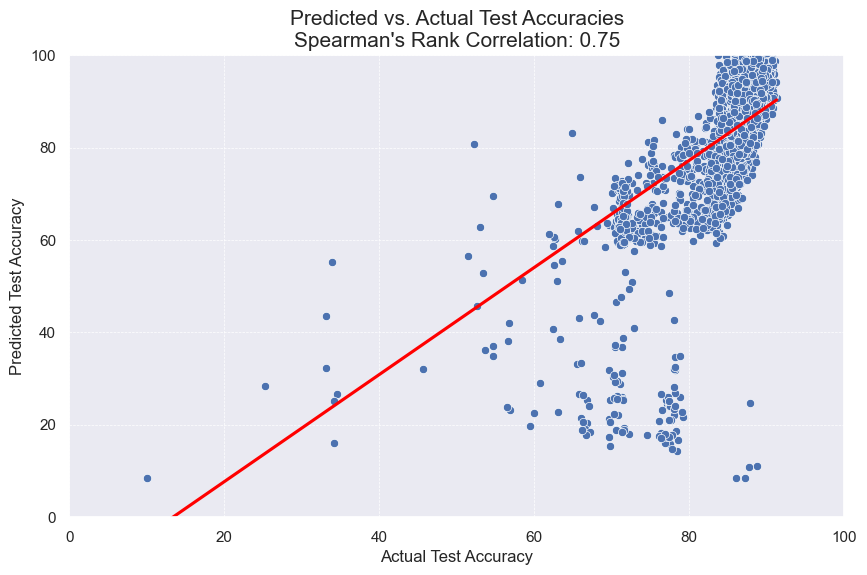

In [22]:
model.eval()  # Set the model to evaluation mode
predicted_accuracies = []
actual_accuracies = []

model.eval()  # Ensure model is in evaluation mode

with torch.no_grad():  # No need to track gradients
    for i in range(len(inputs_test)):  # Assuming you want to use all test inputs
        predicted_accuracy = model(inputs_test[i].unsqueeze(0))  # Add batch dimension
        predicted_accuracies.append(predicted_accuracy.item())
        actual_accuracies.append(targets_test[i].item())
        
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Assuming predicted_accuracies and actual_accuracies are available
predicted_accuracies_np = np.array(predicted_accuracies)
actual_accuracies_np = np.array(actual_accuracies)

print(predicted_accuracies_np)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a scatter plot
sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)

# Beautify the plot
plt.title(f'Predicted vs. Actual Test Accuracies\nSpearman\'s Rank Correlation: {spearman_corr:.2f}', fontsize=15)
plt.xlabel('Actual Test Accuracy', fontsize=12)
plt.ylabel('Predicted Test Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Plot a line of best fit
sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.show()

# Hyperparameter Tuner

In [38]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class DynamicModel(nn.Module):
    def __init__(self, input_size, num_layers, hidden_units, output_size):
        super(DynamicModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                in_features = input_size
            else:
                in_features = hidden_units
            out_features = hidden_units
            self.layers.append(nn.Linear(in_features, out_features))
            # Add more layers or dropout if needed
        self.final = nn.Linear(out_features, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        x = self.final(x)
        return x

def objective(trial):
    # Define the search space
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_units = trial.suggest_categorical('hidden_units', [8, 16, 32, 64])
    input_size = 13  # Adjust this based on your dataset
    output_size = 1  # Adjust this based on your dataset

    model = DynamicModel(input_size, num_layers, hidden_units, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Adjust based on your task

    # Assuming train_dataset and test_dataset are already defined
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    model.train()
    for epoch in range(20):  # Number of epochs
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

    # Evaluation loop
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(test_loader.dataset)

    return avg_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2024-03-16 21:29:15,938] A new study created in memory with name: no-name-03df0b7e-4209-4834-9edf-95f2181a3d3c
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_41476/1860640597.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


Epoch 1, Loss: 3696642784.4476337
Epoch 2, Loss: 72993923.75259624
Epoch 3, Loss: 884448.6435075
Epoch 4, Loss: 113223.06562125
Epoch 5, Loss: 100054.59853
Epoch 6, Loss: 89685.111029375
Epoch 7, Loss: 80242.122981875
Epoch 8, Loss: 71933.99853359375
Epoch 9, Loss: 62502.38846328125
Epoch 10, Loss: 54762.70514546875
Epoch 11, Loss: 47896.24542125
Epoch 12, Loss: 42167.40567886719
Epoch 13, Loss: 37544.260522182616
Epoch 14, Loss: 33622.78169207031
Epoch 15, Loss: 29990.029788515625
Epoch 16, Loss: 26885.90521131836
Epoch 17, Loss: 23986.6752240625
Epoch 18, Loss: 21144.059876025392


[I 2024-03-16 21:29:19,065] Trial 0 finished with value: 1122.5020274414062 and parameters: {'lr': 1.091716460514072e-05, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 32}. Best is trial 0 with value: 1122.5020274414062.


Epoch 19, Loss: 18638.363484746093
Epoch 20, Loss: 16344.044889423829
Epoch 1, Loss: 35749118449.214195
Epoch 2, Loss: 1485365059.1279857
Epoch 3, Loss: 137290.7667953296
Epoch 4, Loss: 220.1119936767578
Epoch 5, Loss: 77.51040628662109
Epoch 6, Loss: 19055.67503284668
Epoch 7, Loss: 730.8844746728515
Epoch 8, Loss: 152.95158506591798
Epoch 9, Loss: 2443.1569393774416
Epoch 10, Loss: 67522.61600413574
Epoch 11, Loss: 76.26536029785156
Epoch 12, Loss: 66.44605370635986
Epoch 13, Loss: 61.80832492797852
Epoch 14, Loss: 55.87767501953125
Epoch 15, Loss: 49.20816140625
Epoch 16, Loss: 91.22887997314453
Epoch 17, Loss: 96.52018475341796
Epoch 18, Loss: 68.2437647668457
Epoch 19, Loss: 61.074641576538085
Epoch 20, Loss: 57.39521470458985


[I 2024-03-16 21:29:23,175] Trial 1 finished with value: 60.99546980041504 and parameters: {'lr': 0.017984409567216263, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 64}. Best is trial 1 with value: 60.99546980041504.


Epoch 1, Loss: 70960866394.51276
Epoch 2, Loss: 15499.225901228026
Epoch 3, Loss: 7003.746474921875
Epoch 4, Loss: 13158.671108978271
Epoch 5, Loss: 39848.05632303467
Epoch 6, Loss: 41904.35060663818
Epoch 7, Loss: 59388.71574591736
Epoch 8, Loss: 28235.616250078125
Epoch 9, Loss: 18273.78970232422
Epoch 10, Loss: 20967.9446702536
Epoch 11, Loss: 18878.776515316164
Epoch 12, Loss: 26976.739830520935
Epoch 13, Loss: 24927.40709100708
Epoch 14, Loss: 29076.442950272216
Epoch 15, Loss: 9937.529593104247
Epoch 16, Loss: 332.16341192138674
Epoch 17, Loss: 494.13454743530275
Epoch 18, Loss: 2935.138133276367


[I 2024-03-16 21:29:24,677] Trial 2 finished with value: 866835.1234452929 and parameters: {'lr': 0.0011206769373347894, 'batch_size': 64, 'num_layers': 1, 'hidden_units': 16}. Best is trial 1 with value: 60.99546980041504.


Epoch 19, Loss: 4107.670357443542
Epoch 20, Loss: 555714.5099674268
Epoch 1, Loss: 598241695.4499098
Epoch 2, Loss: 12313805.384867305
Epoch 3, Loss: 276176.2756242676
Epoch 4, Loss: 2584.8447494116213
Epoch 5, Loss: 1839.8164817626953
Epoch 6, Loss: 1659.766071208496
Epoch 7, Loss: 1478.212701508789
Epoch 8, Loss: 1308.0824460253907
Epoch 9, Loss: 1166.781869597168
Epoch 10, Loss: 1038.491538823242
Epoch 11, Loss: 923.3015654541016
Epoch 12, Loss: 809.5134358691406
Epoch 13, Loss: 717.9351464990234
Epoch 14, Loss: 625.0954079199219
Epoch 15, Loss: 548.8548812329102
Epoch 16, Loss: 519.4092914892578
Epoch 17, Loss: 1642.3966237841796
Epoch 18, Loss: 10817.867292087401
Epoch 19, Loss: 382.7862705639648


[I 2024-03-16 21:29:30,850] Trial 3 finished with value: 98.29620204589844 and parameters: {'lr': 4.0755305130974366e-05, 'batch_size': 16, 'num_layers': 3, 'hidden_units': 8}. Best is trial 1 with value: 60.99546980041504.


Epoch 20, Loss: 481.48516860961917
Epoch 1, Loss: 66509663508.65014
Epoch 2, Loss: 2561972.946461738
Epoch 3, Loss: 159270.08617507812
Epoch 4, Loss: 63559.79879873077
Epoch 5, Loss: 143574.62742620148
Epoch 6, Loss: 36376.44288599991
Epoch 7, Loss: 327034.2925667667
Epoch 8, Loss: 676.3018318737793
Epoch 9, Loss: 33903806.06886357
Epoch 10, Loss: 102224049.31873143
Epoch 11, Loss: 12812.679557750549
Epoch 12, Loss: 259540014.32494065
Epoch 13, Loss: 12893.588521825866
Epoch 14, Loss: 249963.86149301575
Epoch 15, Loss: 272221140.63340926
Epoch 16, Loss: 20719.050399978332
Epoch 17, Loss: 12223.37363953003
Epoch 18, Loss: 161111334.7183833
Epoch 19, Loss: 57819417.99628748


[I 2024-03-16 21:29:35,026] Trial 4 finished with value: 35000457.450438425 and parameters: {'lr': 0.00013256677229009505, 'batch_size': 16, 'num_layers': 1, 'hidden_units': 32}. Best is trial 1 with value: 60.99546980041504.


Epoch 20, Loss: 4425461.904162028
Epoch 1, Loss: 21190726409.762444
Epoch 2, Loss: 193369968.41050702
Epoch 3, Loss: 764601.0292246875
Epoch 4, Loss: 23609.625963828126
Epoch 5, Loss: 16084.547682578124
Epoch 6, Loss: 10258.326246953126
Epoch 7, Loss: 6010.567169179688
Epoch 8, Loss: 3256.3177872460938
Epoch 9, Loss: 970.9398526464844
Epoch 10, Loss: 247.34721814453124
Epoch 11, Loss: 148.15391505371093
Epoch 12, Loss: 136.65545552246093
Epoch 13, Loss: 132.42815947753905
Epoch 14, Loss: 127.54243062011719
Epoch 15, Loss: 120.68566038085937
Epoch 16, Loss: 112.62417690429687
Epoch 17, Loss: 105.4445801953125
Epoch 18, Loss: 98.87103422363282
Epoch 19, Loss: 91.32597354492188


[I 2024-03-16 21:29:37,938] Trial 5 finished with value: 61.31610873535156 and parameters: {'lr': 7.143892787033519e-05, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 16}. Best is trial 1 with value: 60.99546980041504.


Epoch 20, Loss: 81.56027209960938
Epoch 1, Loss: 134609125812.3118
Epoch 2, Loss: 465628253.72319883
Epoch 3, Loss: 72744.89094156677
Epoch 4, Loss: 1684848.3229818817
Epoch 5, Loss: 64.88293904602051
Epoch 6, Loss: 19372196.97727998
Epoch 7, Loss: 2299.685558352432
Epoch 8, Loss: 35.46855740539551
Epoch 9, Loss: 36133977.31320735
Epoch 10, Loss: 2246.7773424169923
Epoch 11, Loss: 1131526703.7895477
Epoch 12, Loss: 1604814254.710657
Epoch 13, Loss: 3209.1323760546875
Epoch 14, Loss: 369.85898638427733
Epoch 15, Loss: 127.82025905029298
Epoch 16, Loss: 78.46124323486328
Epoch 17, Loss: 55.00440802124024
Epoch 18, Loss: 42.35252857543945
Epoch 19, Loss: 44.83555623352051


[I 2024-03-16 21:29:43,767] Trial 6 finished with value: 32.23321673828125 and parameters: {'lr': 0.018199377530045715, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 37.90594654830932
Epoch 1, Loss: 149057977078.74847
Epoch 2, Loss: 16510686.2725875
Epoch 3, Loss: 3475.3797503125
Epoch 4, Loss: 1301.3896219140624
Epoch 5, Loss: 1030.1336332226563
Epoch 6, Loss: 858.1106199316406
Epoch 7, Loss: 659.6199649658203
Epoch 8, Loss: 632.8680741699219
Epoch 9, Loss: 967.1891736621094
Epoch 10, Loss: 3907.4063253759764
Epoch 11, Loss: 24936.838287319337
Epoch 12, Loss: 114136.38202568848
Epoch 13, Loss: 144044.68131015624
Epoch 14, Loss: 131603.02292994142
Epoch 15, Loss: 648.3681446386719
Epoch 16, Loss: 4785.680843793945
Epoch 17, Loss: 3176.0536085546873
Epoch 18, Loss: 2022.8496359375
Epoch 19, Loss: 1820.3655906176757


[I 2024-03-16 21:29:44,797] Trial 7 finished with value: 441.6021235644531 and parameters: {'lr': 0.004749027802841343, 'batch_size': 128, 'num_layers': 1, 'hidden_units': 8}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 1510.2422930078126
Epoch 1, Loss: 18314312619.7078
Epoch 2, Loss: 227280.01770136718
Epoch 3, Loss: 2882747404.2872596
Epoch 4, Loss: 69436.85766031005
Epoch 5, Loss: 36242.205796618655
Epoch 6, Loss: 158981.84672449707
Epoch 7, Loss: 389775.7502569727
Epoch 8, Loss: 294128656.6790294
Epoch 9, Loss: 3111662455.720242
Epoch 10, Loss: 884533.6808287766
Epoch 11, Loss: 175698.0796009427
Epoch 12, Loss: 543996.8189530007
Epoch 13, Loss: 815322637.0229931
Epoch 14, Loss: 1950.7440037234496
Epoch 15, Loss: 17804.066289821778
Epoch 16, Loss: 342027140.89474916
Epoch 17, Loss: 4284728.692911522
Epoch 18, Loss: 573704638.0041307
Epoch 19, Loss: 233970.41813755006


[I 2024-03-16 21:29:48,815] Trial 8 finished with value: 447109480.0892217 and parameters: {'lr': 0.0012811016102147151, 'batch_size': 16, 'num_layers': 1, 'hidden_units': 8}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 1599592.5324599806
Epoch 1, Loss: 14384463169.93535
Epoch 2, Loss: 275127940.9667391
Epoch 3, Loss: 443087802.4701443
Epoch 4, Loss: 1021601430.2962806
Epoch 5, Loss: 12716375.89731495
Epoch 6, Loss: 73204.19123640869
Epoch 7, Loss: 313065.10606396483
Epoch 8, Loss: 607897583.4283103
Epoch 9, Loss: 92134.56280900391
Epoch 10, Loss: 31117.40434741211
Epoch 11, Loss: 6019.662857666016
Epoch 12, Loss: 5502.918050756836
Epoch 13, Loss: 8519.819611040039
Epoch 14, Loss: 224907.91023205078
Epoch 15, Loss: 3236112.476210061
Epoch 16, Loss: 263295.5679848682
Epoch 17, Loss: 345.0126994042969
Epoch 18, Loss: 298.7504697558594
Epoch 19, Loss: 315.4254529199219


[I 2024-03-16 21:29:51,217] Trial 9 finished with value: 371.87065348632814 and parameters: {'lr': 0.00500589871195809, 'batch_size': 32, 'num_layers': 1, 'hidden_units': 16}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 240.1598360546875
Epoch 1, Loss: 3772009430630.3374
Epoch 2, Loss: 6961.412325
Epoch 3, Loss: 6957.5498978125
Epoch 4, Loss: 6953.1649878125
Epoch 5, Loss: 6944.54753296875
Epoch 6, Loss: 6935.43682359375
Epoch 7, Loss: 6926.7197775
Epoch 8, Loss: 6916.94086265625
Epoch 9, Loss: 6903.8215040625
Epoch 10, Loss: 7023.07752015625
Epoch 11, Loss: 7125.760690625
Epoch 12, Loss: 7123.13070515625
Epoch 13, Loss: 7120.1967859375
Epoch 14, Loss: 7116.93218140625
Epoch 15, Loss: 7113.30518125
Epoch 16, Loss: 7109.2825146875
Epoch 17, Loss: 7104.82589734375
Epoch 18, Loss: 7099.89377625
Epoch 19, Loss: 7094.4409996875


[I 2024-03-16 21:29:53,127] Trial 10 finished with value: 7132.6567803125 and parameters: {'lr': 0.06444547214750082, 'batch_size': 64, 'num_layers': 2, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 7088.4141228125
Epoch 1, Loss: 44961527585325.75
Epoch 2, Loss: 195215305.21532
Epoch 3, Loss: 1242834.4260904687
Epoch 4, Loss: 9065.1819915625
Epoch 5, Loss: 7510.7704315625
Epoch 6, Loss: 5825.23339359375
Epoch 7, Loss: 5125.3250221875
Epoch 8, Loss: 4595.016306796875
Epoch 9, Loss: 4117.9032828125
Epoch 10, Loss: 3685.2567903125
Epoch 11, Loss: 3272.891837734375
Epoch 12, Loss: 2889.887981875
Epoch 13, Loss: 2532.870835234375
Epoch 14, Loss: 2209.64039875
Epoch 15, Loss: 1916.363105859375
Epoch 16, Loss: 1654.6411753125
Epoch 17, Loss: 1411.9086785546874


[I 2024-03-16 21:29:54,594] Trial 11 finished with value: 2906.4544367382814 and parameters: {'lr': 0.09433251351197658, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 18, Loss: 1199.3448675390625
Epoch 19, Loss: 1015.6696861914063
Epoch 20, Loss: 855.602574296875
Epoch 1, Loss: 10399109742.161833
Epoch 2, Loss: 742462.0550163379
Epoch 3, Loss: 204.51152396728514
Epoch 4, Loss: 55.21804329879761
Epoch 5, Loss: 97.22462954162597
Epoch 6, Loss: 384.1754251574707
Epoch 7, Loss: 59.39856981933594
Epoch 8, Loss: 46.3833659765625
Epoch 9, Loss: 39.296754601745604
Epoch 10, Loss: 37.53233386352539
Epoch 11, Loss: 34.457071556396485
Epoch 12, Loss: 31.771520680541993
Epoch 13, Loss: 30.502731406555174
Epoch 14, Loss: 29.87811630737305
Epoch 15, Loss: 28.94385106933594
Epoch 16, Loss: 28.44184885040283
Epoch 17, Loss: 26.733567224731445
Epoch 18, Loss: 27.366292603149414
Epoch 19, Loss: 34.81892764404297
Epoch 20, Loss: 10701695.170859326


[I 2024-03-16 21:29:58,661] Trial 12 finished with value: 120.54024415405273 and parameters: {'lr': 0.015787002829680707, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 1, Loss: 6068826182.871269
Epoch 2, Loss: 787199910.785798
Epoch 3, Loss: 400489531.2957753
Epoch 4, Loss: 212.57622787292482
Epoch 5, Loss: 123.86499542572021
Epoch 6, Loss: 111.8570214440918
Epoch 7, Loss: 63.44601056152344
Epoch 8, Loss: 95.33513057388306
Epoch 9, Loss: 64.73935234817505
Epoch 10, Loss: 41.33336266723633
Epoch 11, Loss: 48.11750021606445
Epoch 12, Loss: 49.111770914764406
Epoch 13, Loss: 39.90835887390137
Epoch 14, Loss: 34.07888741043091
Epoch 15, Loss: 32.31623014633179
Epoch 16, Loss: 830.2930796586609
Epoch 17, Loss: 180.38549669296265
Epoch 18, Loss: 152.02226914237977
Epoch 19, Loss: 109.99315742656708


[I 2024-03-16 21:30:10,927] Trial 13 finished with value: 98.39627157226562 and parameters: {'lr': 0.013577637984452056, 'batch_size': 16, 'num_layers': 3, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 73.79445412155151
Epoch 1, Loss: 91036404612.9953
Epoch 2, Loss: 10802.356696122437
Epoch 3, Loss: 23365515.55777367
Epoch 4, Loss: 51.30383270751953
Epoch 5, Loss: 65.1775225036621
Epoch 6, Loss: 35.90002141845703
Epoch 7, Loss: 32.45462887359619
Epoch 8, Loss: 36.46482908477783
Epoch 9, Loss: 34.29309599822998
Epoch 10, Loss: 31.536120114898683
Epoch 11, Loss: 56.21420114074707
Epoch 12, Loss: 40.642926239624025
Epoch 13, Loss: 38.87935303588867
Epoch 14, Loss: 29.876221120605468
Epoch 15, Loss: 450743.94470722775
Epoch 16, Loss: 6879.31531140625
Epoch 17, Loss: 6786.6337315625
Epoch 18, Loss: 745.0745202270508
Epoch 19, Loss: 155.3025937487793


[I 2024-03-16 21:30:17,354] Trial 14 finished with value: 95.84567420898438 and parameters: {'lr': 0.020327450231681303, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 108.71049176757812
Epoch 1, Loss: 29034720499.569035
Epoch 2, Loss: 173652882.76674926
Epoch 3, Loss: 1783406440.200692
Epoch 4, Loss: 15179.423964270325
Epoch 5, Loss: 47467.48310987259
Epoch 6, Loss: 1069110103.9752697
Epoch 7, Loss: 29259.022340763855
Epoch 8, Loss: 185.63868188415526
Epoch 9, Loss: 74122.94798856766
Epoch 10, Loss: 2419400.79496942
Epoch 11, Loss: 27857638.18314334
Epoch 12, Loss: 754.8317417092132
Epoch 13, Loss: 918216.986549151
Epoch 14, Loss: 1325.678332124176
Epoch 15, Loss: 1165962.0711268412
Epoch 16, Loss: 67674815.72844581
Epoch 17, Loss: 8647687.164986411
Epoch 18, Loss: 175214.50268694488
Epoch 19, Loss: 70170.31673663696


[I 2024-03-16 21:30:23,185] Trial 15 finished with value: 88110.78963 and parameters: {'lr': 0.0027690509732109106, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 210344.83308448302
Epoch 1, Loss: 6364450840.977493
Epoch 2, Loss: 281917.2530919336
Epoch 3, Loss: 764.7767526269531
Epoch 4, Loss: 606.1755791625976
Epoch 5, Loss: 427.59823192108155
Epoch 6, Loss: 5977.729118150634
Epoch 7, Loss: 6690.907847863159
Epoch 8, Loss: 8818.819932650757
Epoch 9, Loss: 1968.48082329895
Epoch 10, Loss: 3494.277336184082
Epoch 11, Loss: 20479.884563276366
Epoch 12, Loss: 29600.847657851562
Epoch 13, Loss: 13776.876158448486
Epoch 14, Loss: 5233.233079238891
Epoch 15, Loss: 1697.6240937530517
Epoch 16, Loss: 1084.4083519082642
Epoch 17, Loss: 560.5753679147339


[I 2024-03-16 21:30:24,727] Trial 16 finished with value: 80.40973430175781 and parameters: {'lr': 0.00029169583272410296, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 18, Loss: 530.9944056277466
Epoch 19, Loss: 25.22200248626709
Epoch 20, Loss: 116.3687450970459
Epoch 1, Loss: 674561915802.3103
Epoch 2, Loss: 7120.91475484375
Epoch 3, Loss: 7120.103775
Epoch 4, Loss: 7119.05360375
Epoch 5, Loss: 7117.77203
Epoch 6, Loss: 7116.2563025
Epoch 7, Loss: 7114.4975740625
Epoch 8, Loss: 7112.4831415625
Epoch 9, Loss: 7110.1947003125
Epoch 10, Loss: 7107.61349375
Epoch 11, Loss: 7104.71546234375
Epoch 12, Loss: 7101.47354359375
Epoch 13, Loss: 7097.8582146875
Epoch 14, Loss: 7093.83574
Epoch 15, Loss: 7089.3686496875
Epoch 16, Loss: 7084.41551140625
Epoch 17, Loss: 7078.92877484375
Epoch 18, Loss: 7072.855365
Epoch 19, Loss: 7066.14216875


[I 2024-03-16 21:30:26,702] Trial 17 finished with value: 7097.16674078125 and parameters: {'lr': 0.03369318034131746, 'batch_size': 64, 'num_layers': 2, 'hidden_units': 64}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 7058.7258121875
Epoch 1, Loss: 5633097553.710632
Epoch 2, Loss: 288056.0933651251
Epoch 3, Loss: 1638492.4244817407
Epoch 4, Loss: 649168.5703794189
Epoch 5, Loss: 379203.56396164
Epoch 6, Loss: 40665933.393783465
Epoch 7, Loss: 252912.24916470674
Epoch 8, Loss: 42.966129612426755
Epoch 9, Loss: 34.54593753845215
Epoch 10, Loss: 111.24783351745606
Epoch 11, Loss: 21791.48948621216
Epoch 12, Loss: 140633050.8514615
Epoch 13, Loss: 702.4619690252686
Epoch 14, Loss: 412.8217712597656
Epoch 15, Loss: 45.542708650360105
Epoch 16, Loss: 42.547152496337894
Epoch 17, Loss: 34.183647893981934
Epoch 18, Loss: 107.99783257324219
Epoch 19, Loss: 65.02841206787109


[I 2024-03-16 21:30:30,392] Trial 18 finished with value: 33.3233891998291 and parameters: {'lr': 0.008110161483603336, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 6 with value: 32.23321673828125.


Epoch 20, Loss: 44.37122326721192
Epoch 1, Loss: 24375884329.780064
Epoch 2, Loss: 337739.2444915747
